In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import norm
%matplotlib notebook
import matplotlib as mpl
import matplotlib.patches as patches
from datetime import datetime
from matplotlib.cbook import get_sample_data
plt.style.use('seaborn')

## Create a hitmap that is 20*20

In [39]:
def get_gaussian_weights(value, stds):
    
    '''
    return the weights for the time, longitude, and latitude for interpolation
    Uses the Gaussian distribution 
    
    param: values = list with [longitude, latitude, time] of that point
    param: stds = list with custom stds for [time, lon, lat]
    '''
    
    lon, lat, time = tuple(value)
    lon_std, lat_std, time_std = tuple(stds)
    
    z_lon = (df['Lon'] - lon) / lon_std
    z_lat = (df['Lat'] - lat) / lat_std
    z_time = (df['secDay'] - time) / time_std
    
    # finds the weights
    w_lon = norm.pdf(z_lon)
    w_lat = norm.pdf(z_lat)
    w_time = norm.pdf(z_time)
    
    return w_lon, w_lat, w_time

In [40]:
def get_data_for_heatmap(lons, lats, time, dists, heatmap_size, col_name='sw pCO2 (uatm)', time_factor=1, size_factor=1):
    
    dist_lon, dist_lat, dist_time = tuple(dists) 
    stds=[dist_lon * size_factor, dist_lat * size_factor, dist_time * time_factor]

    data = np.zeros((heatmap_size, heatmap_size))
    for i, lat in enumerate(lats):
        
        data_arr = []
        
        for lon in lons:
            w_lon, w_lat, w_time = get_gaussian_weights((lon, lat, time), stds=stds)
            
            X = df[col_name].values
            val = np.sum(X * w_time * w_lon * w_lat) / np.sum(w_time * w_lon * w_lat)            
            data_arr.append(val)
        
        data[i, :] = data_arr
        
    return data

In [41]:
NW = (-70.14655, 43.72273)
NE = (-70.14619, 43.72253)
SE = (-70.14876, 43.72015)
SW = (-70.14911, 43.72035)
corners = [NW, NE, SE, SW]

# Zooming in

In [5]:
def get_boundary_box(corners, R=6378137):
    '''
    Corners follow the order NW, NE, SE, SW, (longitude, latitude)
    
    returns: upperbound, lower bound, right bound, left bound
    '''
    northmost = max(corners, key=lambda x: x[0])
    southmost = min(corners, key=lambda x: x[0])
    eastmost = max(corners, key=lambda x: x[1])
    westmost = min(corners, key=lambda x: x[1])  
    
    def get_coords_from_offsets(dn, de, coord):
        
        lon, lat = coord
        
        #Coordinate offsets in radians
        dLat = dn/R
        dLon = de/(R*np.cos(np.pi*lat/180))

        #//OffsetPosition, decimal degrees
        latO = lat + dLat * 180/np.pi
        lonO = lon + dLon * 180/np.pi 
        return (lonO, latO)
    
    # offsets in meters for north
    dn = 300
    de = 0
    
    _, north_lat = get_coords_from_offsets(dn, de, northmost)
    
    # offsets in meters for south
    dn = -300
    de = 0
    
    _, south_lat = get_coords_from_offsets(dn, de, southmost)
    
    # offsets in meters for east
    dn = 0
    de = 300
    
    east_lon, _ = get_coords_from_offsets(dn, de, eastmost)
    
    # offsets in meters for east
    dn = 0
    de = -300
    
    west_lon, _ = get_coords_from_offsets(dn, de, westmost)
    
#     corners = [(west_lon, north_lat), (east_lon, north_lat), (west_lon, south_lat), (east_lon, south_lat)]
    
    return [north_lat, south_lat, east_lon, west_lon]

In [66]:
df = pd.read_csv('FLO_L3_20170502.csv', skiprows=[1])

# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
# df = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
column_to_graph = 'sw pCO2 (uatm)'
# column_to_graph = 'L1_fCO2'
df = df[['Lat', 'Lon', 'secDay', column_to_graph]]
df.dropna(inplace=True)

# filter out pCO2 values that are outliers
# df = df[(df[column_to_graph] > 100) & (df[column_to_graph] < 600)]

# removes outliers, if necessary.
m = 2 # number of standard deviations away
z_scores = (df[column_to_graph] - df[column_to_graph].mean()) / df[column_to_graph].std()
df = df[z_scores < m]  

# bounds the graph within 300 meters of the farm
boundary = get_boundary_box(corners)
boundary

df = df[(df['Lat'] < boundary[0]) & 
        (df['Lat'] > boundary[1]) & 
        (df['Lon'] < boundary[2]) & 
        (df['Lon'] > boundary[3])]

heatmap_size = 30
# np.linspace(0, 7, 14, endpoint=False)[1::2]
time_size = 12

# to change the standard deviations
size_factor = 2
time_factor = 2

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]



# Animation

In [67]:
import matplotlib.animation as animation

In [68]:
tides_df_path = 'Tidal_Current Data/CAB1409_prediction_Timeseries_2017-05-02_cleaned.csv'
tides_df = pd.read_csv(tides_df_path)
X = np.array([int(datetime.strptime(x, '%Y-%m-%d %I:%M:%S %p').strftime('%s')) 
              for x in tides_df['Date_Time (GMT)']])
X = X - X.min() # subtracts the min
y = tides_df['Speed (cm/sec)'].values
X_pred = df['secDay'].values
y_pred = np.interp(X_pred, X, y)

In [73]:
total_time = 200  # number of frames
heatmap_size = 20 # number of frames to segregate the heatmaps

# to change the standard deviations
size_factor = 2
time_factor = 2


vmin = df[column_to_graph].min()
vmax = df[column_to_graph].max()
# vmin, vmax = (345, 354)

lon_min = df['Lon'].min()
lon_max = df['Lon'].max()
lat_min = df['Lat'].min()
lat_max = df['Lat'].max()

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), total_time * 2, endpoint=False)[1::2]

In [74]:
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]
def update(curr):
    
    '''
    params: col_name
    params: data: the data of interest for the heatmap
    params: total_time: the number of frames to show
    '''
    
    # check if animation is at the last frame, and if so, stop the animation a    
    
    if curr == total_time - 1:
        a.event_source.stop()
    
    # clears previous images
    prev_boat_ax = plt.gca()
    prev_boat_ax.clear()
    prev_boat_ax.axis('off')
    ax.clear()
    
    # creates a color array
    data_arr = get_data_for_heatmap(lons, lats, times[curr], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor, 
                                    col_name=column_to_graph)
    im = ax.imshow(data_arr, 
                   cmap='jet', 
                   vmin = vmin,
                   vmax = vmax,
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
    ax.set_aspect('auto')
    ax.grid(False)
    
    # adds title and labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # adds the time as the title
    curr_time = datetime.fromtimestamp(times[curr]).strftime('%I:%M:%S %p')
    ax.set_title(curr_time)

    
    # adds the location of the farm
    ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='white', lw=3))
    
    # adds the current direction and speed 
    
    
    # finds the nearest value to the current time frame
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx
    
    closest_time, closest_time_index = find_nearest(df['secDay'].ravel(), times[curr])
    points_to_show = 10
    if curr < points_to_show:
        nearby_points = df.iloc[closest_time_index:closest_time_index + points_to_show]
    elif curr > (total_time - points_to_show):
        nearby_points = df.iloc[closest_time_index - points_to_show:closest_time_index]
    else:
        nearby_points = df.iloc[closest_time_index-points_to_show:closest_time_index + points_to_show]
#     ax.scatter(nearby_points['Lon'], nearby_points['Lat'], c='pink', s=5)

    curr_lat = df.loc[df['secDay'] == closest_time]['Lat'].item()
    curr_lon = df.loc[df['secDay'] == closest_time]['Lon'].item()
    
    # adds direction of current
    pred_current = np.interp(times[curr], X, y)
    direction = np.deg2rad(354) if pred_current > 0 else np.deg2rad(179)
    r = 0.1 * np.sqrt(np.abs(pred_current))  # this is the current. The bigger the current, the bigger the arrow

    center = (0.1, 0.1)
    new_center = (r * np.sin(direction) + center[0], r * np.cos(direction) + center[1]) 

    # draws the arrow direction
    ax.annotate('current direction', xy=new_center, xytext=center, xycoords='axes fraction', color='white',
                arrowprops=dict(facecolor='white', edgecolor='white', width=1, headwidth=5, headlength=5))
    
    
    # imports the boat icon and draws the boat
    boat_path = '/Users/Mike/Data Science/Independent Projects/Kelp Data Analysis and Visualization/motor-boat.png'
    boat_img = plt.imread(get_sample_data(boat_path))
    
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    boat_size = ax_width/(fig_width*10)
    
    loc = ax.transData.transform((curr_lon, curr_lat))
    boat_ax = fig.add_axes([loc[0]/fig_width-boat_size/2, loc[1]/fig_height-boat_size/2,
                            boat_size, boat_size], anchor='C')
    boat_ax.imshow(boat_img)
    boat_ax.axis("off")
    
#     ax.scatter(curr_lon, curr_lat, c='black', s=25)
    
    plt.tight_layout()


<IPython.core.display.Javascript object>


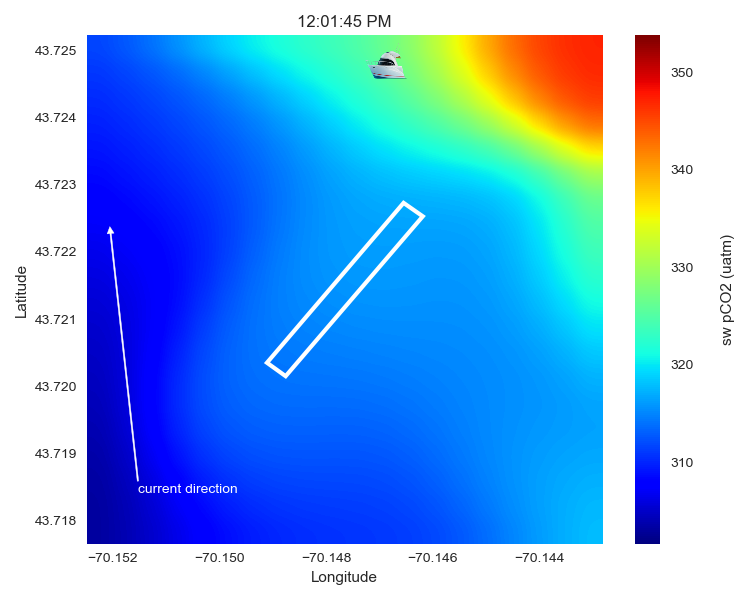

In [75]:
fig, ax = plt.subplots(figsize=(7.5,6))
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

ax.set_xlim(df['Lon'].min(), df['Lon'].max())
ax.set_ylim(df['Lat'].min(), df['Lat'].max())
ax.set_title('time: 0')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('auto')
# plt.gca().set_ylabel('Longitude')
# plt.gca().set_xlabel('Latitude')


data = np.linspace(vmin, vmax, 100).reshape(10, 10)
im = ax.imshow(data, cmap='jet')
plt.cla()
cbar = fig.colorbar(im)
cbar.set_label(r'{}'.format('sw pCO2 (uatm)'), rotation=90, labelpad=20)

plt.tight_layout()

a = animation.FuncAnimation(fig, update, interval=250, frames=1000, save_count=500, repeat=False)

In [38]:
len(df['secDay'])

446

In [76]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
a.save('Custom_animation_with_boat_may_2017.mp4', writer=writer)

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


IndexError: index 200 is out of bounds for axis 0 with size 200

In [44]:
df.loc[df['secDay'] == 52328]['Lat'].item()

43.7218

In [45]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [49]:
closest_time = find_nearest(df['secDay'].ravel(), times[1])
curr_lat = df.loc[df['secDay'] == closest_time]['Lat']
curr_lon = df.loc[df['secDay'] == closest_time]['Lon']

In [50]:
curr_lon

210   -70.145195
Name: Lon, dtype: float64

<IPython.core.display.Javascript object>


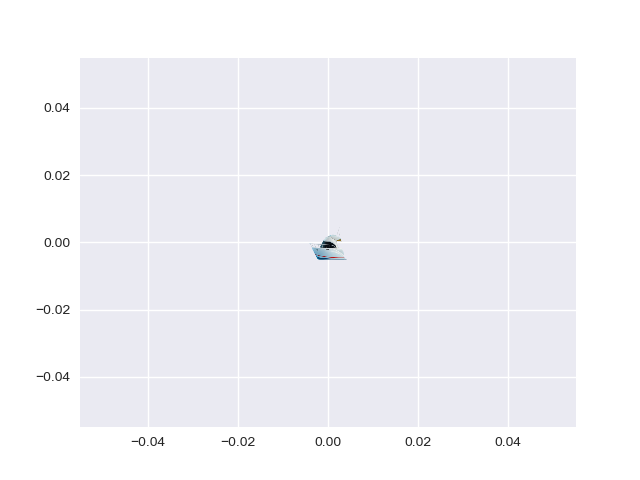

In [30]:
from matplotlib.cbook import get_sample_data

# poo-mark came from emojipedia:
# https://emojipedia-us.s3.amazonaws.com/thumbs/120/apple/96/pile-of-poo_1f4a9.png
boat_img = plt.imread(get_sample_data("/Users/Mike/Data Science/Independent Projects/Kelp Data Analysis and Visualization/motor-boat.png"))

x = np.linspace(0, 2*np.pi, num=1)
y = np.sin(x)

fig, ax = plt.subplots()
plot = ax.plot(x, y, linestyle="-")

ax_width = ax.get_window_extent().width
fig_width = fig.get_window_extent().width
fig_height = fig.get_window_extent().height
boat_size = ax_width/(fig_width*10)
boat_axs = [None for i in range(len(x))]
for i in range(len(x)):
    loc = ax.transData.transform((x[i], y[i]))
    boat_axs[i] = fig.add_axes([loc[0]/fig_width-boat_size/2, loc[1]/fig_height-boat_size/2,
                               boat_size, boat_size], anchor='C')
    boat_axs[i].imshow(boat_img)
    boat_axs[i].axis("off")

In [77]:
df['secDay'][141]

52188.0

In [80]:
datetime.fromtimestamp(52188).strftime('%I:%M:%S %p')

'09:29:48 AM'

In [88]:
df.columns

Index(['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L',
       'Chl a (mg/m3)', 'sw pCO2 (uatm)'],
      dtype='object')